# Paired integration tutorial

In this notebook we showcase basic Multigrate functionality and integrate a CITE-seq dataset to obtain a joint gene expression and protein abundance representation in a latent space. We use publically available dataset from NeurIPS 2021 workshop https://openproblems.bio/neurips_2021/.

The preprocessed data can be downloaded from https://drive.google.com/drive/folders/1SJeo1OYM__h8vB6dXzGWC8FcLV5fUmgZ?usp=sharing.

In [1]:
import numpy as np
import scanpy as sc
import multigrate as mtg

import warnings
warnings.filterwarnings('ignore')

Global seed set to 0


In [2]:
# rna = sc.read('neurips-cite/rna_hvg.h5ad')
rna = sc.read('/lustre/groups/ml01/workspace/anastasia.litinetskaya/data/neurips-cite/rna_hvg.h5ad')
rna

AnnData object with n_obs × n_vars = 90261 × 4000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dataset_id', 'genome', 'hvg', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [3]:
# adt = sc.read('neurips-cite/protein.h5ad')
adt = sc.read('/lustre/groups/ml01/workspace/anastasia.litinetskaya/data/neurips-cite/protein.h5ad')
adt

AnnData object with n_obs × n_vars = 90261 × 134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

We subset to two sites in this tutorial to minimize the training time.

In [4]:
rna = rna[rna.obs['Site'].isin(['site1', 'site2'])]
rna

View of AnnData object with n_obs × n_vars = 41482 × 4000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dataset_id', 'genome', 'hvg', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [5]:
adt = adt[adt.obs['Site'].isin(['site1', 'site2'])]
adt

View of AnnData object with n_obs × n_vars = 41482 × 134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

## Prep the input AnnData object

First, we need to organize anndatas correspoding to different datasets and modalities into 1 anndata object. In this example we have 1 CITE-seq dataset, hence we input 2 anndata objects, 1 for RNA modality, 1 for ADT modality, and specify that they are paired (```groups``` argument).

Notes:
- paired datasets have to have the same .obs_names, i.e. index

A couple of examples on how to initialize the data and the model:
- each sublist in `adatas`, `groups`, `layers` parameters correspond to one modality. If you have multiple objects per modality, append them to the corresponding list. If you have paired and unpaired measurements, the missing data should be registered with `None` (see examples below)
- objects in each sublist *have* to have the same set of features: if you want to integrate multiple RNA objects, we recommend first concatenating full objects and then subsetting to 3000-4000 highly variable genes; for ADT modality, we take the intersection of available proteins (double check the naming conventions, as that can vary a lot from one dataset to another, so `.var_names` can have almost no intersection but if you align the protein names, then there is an overlap)
- one paired CITE-seq experiment:
```
adatas = [[rna], [adt]],
groups = [[0], [0]],
```
- one paired CITE-seq experiment and another RNA dataset:
```
adatas = [[rna_cite, rna], [adt_cite, None]],
groups = [[0, 1], [0, 1]],
layers = [['counts', None], [None, None]]
```
- `layers` parameter specifies which layer the model should take the counts from. If `None`, then defaults to `.X`. The distribution of the input data should be the same within a modality, i.e. either use raw counts for all RNA onjects or all normalized

In [6]:
# check that obs_names are indeed the same
np.sum(rna.obs_names != adt.obs_names)

0

In [7]:
adata = mtg.data.organize_multiome_anndatas(
    adatas = [[rna], [adt]],           # a list of anndata objects per modality, RNA-seq always goes first
    groups = [[0], [0]],               # groups that specify which anndatas are paired
    layers = [['counts'], [None]],     # if need to use data from .layers, if None use .X
    modality_lengths = [[4000], [134]] # how many features in each modality
)
adata

AnnData object with n_obs × n_vars = 41482 × 4134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'group'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'counts'

From now on, we work with one concatenated anndata object ```adata```.

If using raw counts for scRNA, we need to use NB loss (or ZINB), thus need to calculate `size_factors` first. If using normalized counts and MSE for scRNA, `rna_indices_end` does not need to be specified.

In [8]:
mtg.model.MultiVAE.setup_anndata(
    adata,
    rna_indices_end=4000, # how many features in the rna-seq modality
    categorical_covariate_keys=["batch"]
)

INFO     No batch_key inputted, assuming all cells are same batch                                                  
INFO     No label_key inputted, assuming all cells have same label                                                 
INFO     Using data from adata.X                                                                                   
INFO     Successfully registered anndata object containing 41482 cells, 4134 vars, 1 batches, 1 labels, and 0      
         proteins. Also registered 1 extra categorical covariates and 1 extra continuous covariates.               
INFO     Please do not further modify adata until model is trained.                                                


If categorical (e.g. sex) or continious covariates (e.g. age) are available, and you'd like to learn a latent representation disentangled from these covariates, additionally specify in setup_anndata
```
categorical_covariate_keys: ["batch"],
continuous_covariate_keys: ["age"]
```

Here we want to get rid of batch effect, so we specify  `batch` as a categorical covariate.

## Initialize the model

Define the model here. If using raw counts for RNA-seq, use NB loss, if normalized counts, use MSE. For ADT we use CLR-normalized counts and MSE loss.

Usually it is not necessary to specify `integrate_on="batch"` and the model correct for batch effects by learning the latent representation disentangled from the batch. If this fails, then we recommend using `integrate_on` parameter.

We recommend setting `n_layers_encoders` and `n_layers_decoders` to 2 for each modality. Here it's set to 1 to minimize the training time.

In case of the mosaic integration, it might be benefitial to set different weights to different modalities. We recommend first training the model with default equal weights (all equal to `1.0`), then checking the training curves (see below) and then if one of the modalities seem to overpower another (e.g. if one of the loss curves goes down but the other one doesn't) to balance the coefficients accordingly. If there are two modalities `0` and `1` (according to the order in which they were initialized), set the corresponding coeffitients as 
```
loss_coefs = {
   '0': 1.0,
   '1': 0.001
}
```

In [9]:
model = mtg.model.MultiVAE(
    adata, 
    modality_lengths=[4000, 134], # how many features per modality
    losses=['nb', 'mse'],         # what losses to use for each modality
    loss_coefs={'kl': 1e-5,
               'integ': 1e-2}, # 'integ' coef is only used if integrate_on is used
    # integrate_on="batch",
    z_dim=15,
    cond_dim=10,
    dropout=0.2,
    n_layers_encoders=[1, 1],
    n_layers_decoders=[1, 1],
)

## Train the model

Can specify the number of epochs by setting `max_epochs` parameter, default is 500. The default batch size is set to `batch_size = 128`, adjust if needed.

In [10]:
model.train(max_epochs=200)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 200/200: 100%|██████████| 200/200 [15:42<00:00,  4.71s/it, loss=1.11e+03, v_num=1]


Plot losses.

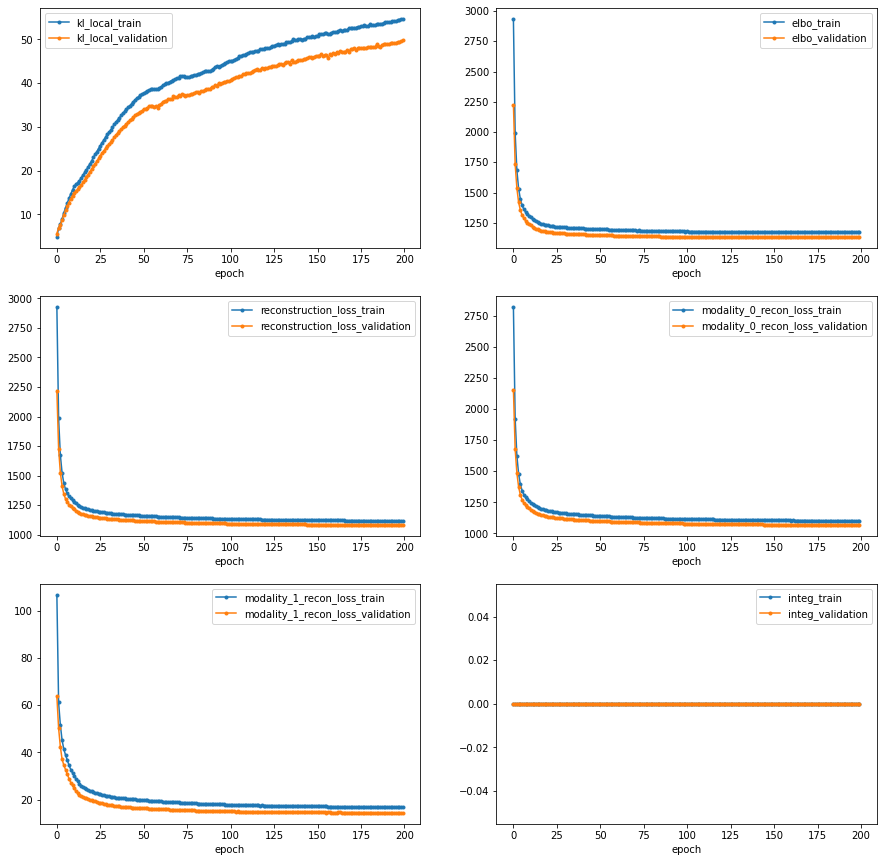

In [11]:
model.plot_losses()

Integration loss is always 0 because we don't explicitely integrate the batches.

## Inference

Get the latent representation.

In [12]:
model.get_latent_representation()
adata

AnnData object with n_obs × n_vars = 41482 × 4134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'group', 'size_factors', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '_scvi'
    obsm: '_scvi_extra_categoricals', '_scvi_extra_continuous', 'latent'
    layers: 'counts'

Visualize results.

In [13]:
sc.pp.neighbors(adata, use_rep='latent')
sc.tl.umap(adata)

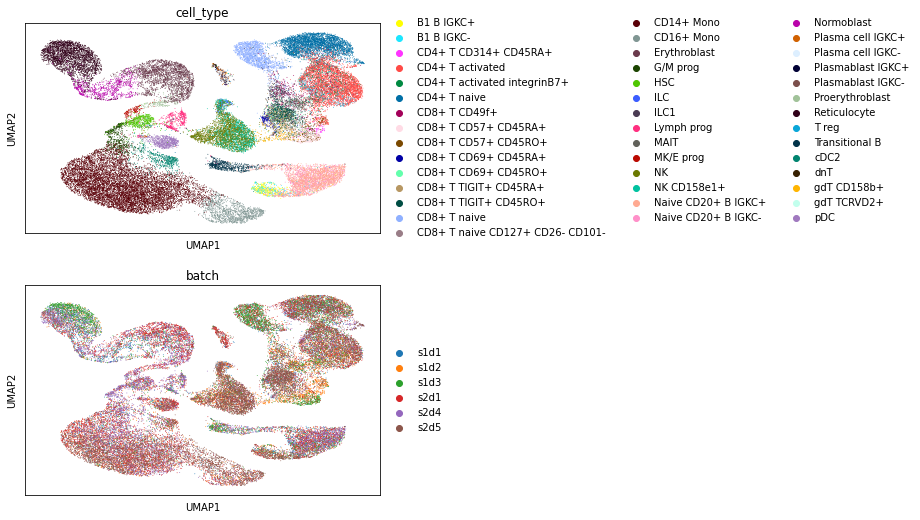

In [14]:
sc.pl.umap(adata, color=['cell_type', 'batch'], ncols=1)